In [ ]:
!pip install openpyxl

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
import keras_tuner as kt


In [ ]:
def load_and_clean_data(file_path):
    """
    Loads data from all sheets in an Excel file and performs thorough cleaning.
    Cleaning includes:
      - Converting 'Date' to datetime and dropping invalid dates.
      - Converting 'Price' to numeric and dropping invalid prices.
      - Aggregating duplicate dates within each sheet (using median).
      - Combining all sheets and aggregating duplicates across sheets.
      - Reindexing to a full daily date range and interpolating missing values.
      - Removing outliers using the IQR method.
    """
    print("=== Loading and Cleaning Data ===")
    try:
        xls = pd.ExcelFile(file_path)
    except Exception as e:
        raise ValueError(f"Failed to open file '{file_path}': {e}")

    print("Available sheets in the Excel file:", xls.sheet_names)
    cleaned_dfs = []  # list to store cleaned DataFrames from each sheet

    for sheet in xls.sheet_names:
        print(f"\n--- Processing Sheet: '{sheet}' ---")
        try:
            df_sheet = pd.read_excel(file_path, sheet_name=sheet)
        except Exception as e:
            print(f"Error loading sheet '{sheet}': {e}")
            continue

        # Ensure required columns exist
        if 'Date' not in df_sheet.columns or 'Price' not in df_sheet.columns:
            print(f"Sheet '{sheet}' skipped: Missing required columns ('Date' and/or 'Price').")
            continue

        # Convert 'Date' to datetime; drop rows with invalid dates
        df_sheet['Date'] = pd.to_datetime(df_sheet['Date'], errors='coerce')
        num_invalid_dates = df_sheet['Date'].isna().sum()
        if num_invalid_dates > 0:
            print(f"Sheet '{sheet}': Dropping {num_invalid_dates} rows with invalid dates.")
        df_sheet.dropna(subset=['Date'], inplace=True)

        # Convert 'Price' to numeric; drop rows with invalid prices
        df_sheet['Price'] = pd.to_numeric(df_sheet['Price'], errors='coerce')
        num_invalid_prices = df_sheet['Price'].isna().sum()
        if num_invalid_prices > 0:
            print(f"Sheet '{sheet}': Dropping {num_invalid_prices} rows with invalid or missing Price values.")
        df_sheet.dropna(subset=['Price'], inplace=True)

        # Sort by date and set 'Date' as index
        df_sheet.sort_values('Date', inplace=True)
        df_sheet.set_index('Date', inplace=True)

        # Remove duplicate dates within this sheet using median (robust to outliers)
        initial_rows = df_sheet.shape[0]
        df_sheet = df_sheet.groupby(df_sheet.index).agg({'Price': 'median'})
        final_rows = df_sheet.shape[0]
        if final_rows < initial_rows:
            print(f"Sheet '{sheet}': Aggregated duplicates within sheet (rows: {initial_rows} -> {final_rows}).")
        else:
            print(f"Sheet '{sheet}': No duplicate dates found.")
        print("Cleaned data preview:")
        print(df_sheet.head())
        cleaned_dfs.append(df_sheet)

    if not cleaned_dfs:
        raise ValueError("No valid sheets found after cleaning.")

    # Combine all sheets into one DataFrame
    combined_df = pd.concat(cleaned_dfs)
    print("\n--- Combined Data (Before Final Cleaning) ---")
    print(f"Combined data shape: {combined_df.shape}")
    print(combined_df.head())

    # Aggregate duplicates across sheets (again using median)
    initial_rows = combined_df.shape[0]
    combined_df = combined_df.groupby(combined_df.index).agg({'Price': 'median'})
    final_rows = combined_df.shape[0]
    if final_rows < initial_rows:
        print(f"\nCombined data: Aggregated duplicates across sheets (rows: {initial_rows} -> {final_rows}).")
    else:
        print("\nCombined data: No duplicate dates across sheets.")

    # Reindex to a full daily date range between the minimum and maximum dates
    full_range = pd.date_range(start=combined_df.index.min(), end=combined_df.index.max(), freq='D')
    combined_df = combined_df.reindex(full_range)
    print("\nAfter reindexing, data shape with full date range:", combined_df.shape)

    # Interpolate missing values (using time interpolation)
    missing_before = combined_df['Price'].isna().sum()
    combined_df['Price'] = combined_df['Price'].interpolate(method='time')
    missing_after = combined_df['Price'].isna().sum()
    print(f"Filled missing values: {missing_before} -> {missing_after} missing values.")

    # Remove outliers using the IQR method
    Q1 = combined_df['Price'].quantile(0.25)
    Q3 = combined_df['Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    initial_rows = combined_df.shape[0]
    combined_df = combined_df[(combined_df['Price'] >= lower_bound) & (combined_df['Price'] <= upper_bound)]
    final_rows = combined_df.shape[0]
    print(f"Outlier removal using IQR: Rows reduced from {initial_rows} to {final_rows}.")

    print("\n=== Final Cleaned Data Summary ===")
    print(f"Total unique dates: {combined_df.shape[0]}")
    print("Date Range:", combined_df.index.min(), "to", combined_df.index.max())
    print("Cleaned Data Preview:")
    print(combined_df.head())

    return combined_df

def create_sequences(dataset, seq_length):
    """
    Creates sequences of length `seq_length` for time series forecasting.
    Returns arrays for input features (X) and target values (y).
    """
    X, y = [], []
    for i in range(seq_length, len(dataset)):
        X.append(dataset[i - seq_length:i, 0])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

def fetch_current_bitcoin_price():
    """
    Fetches the current Bitcoin price in USD using the Coingecko API.
    """
    url = "https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=usd"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        return data["bitcoin"]["usd"]
    except Exception as e:
        print("Error fetching real-time data:", e)
        return None

# Global sequence length variable (used later in model building)
seq_length = 60

def build_model(hp):
    """
    Build and compile the LSTM model. This function is used by KerasTuner.
    """
    model = Sequential()
    # Tune the number of LSTM units and dropout rate
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32, default=64)
    dropout_rate = hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1, default=0.3)

    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))

    # Tune the dense layer size
    dense_units = hp.Int('dense_units', min_value=16, max_value=64, step=16, default=32)
    model.add(Dense(units=dense_units, activation='relu'))
    model.add(Dense(units=1))

    # Tune the learning rate
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='log', default=1e-3)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mean_squared_error')
    return model

In [ ]:
# Load & Clean Data
file_path = 'Bitcon _Research _Dataset.xlsx'
combined_df = load_and_clean_data(file_path)


=== Loading and Cleaning Data ===
Available sheets in the Excel file: ['2017-2024 Stock Data', '2017-2024 currency Data', '2017-2020 SD', '2020-2021 SD', '2021 -2024 SD', '2017-2020 CD', '2020-2021 CD', '2021-2024 CD']

--- Processing Sheet: '2017-2024 Stock Data' ---
Sheet '2017-2024 Stock Data': Aggregated duplicates within sheet (rows: 1802 -> 1801).
Cleaned data preview:
             Price
Date              
2017-09-11  4245.9
2017-09-12  4217.9
2017-09-13  4158.9
2017-09-14  3870.3
2017-09-15  3243.1

--- Processing Sheet: '2017-2024 currency Data' ---
Sheet '2017-2024 currency Data': Aggregated duplicates within sheet (rows: 1802 -> 1801).
Cleaned data preview:
             Price
Date              
2017-09-11  4245.9
2017-09-12  4217.9
2017-09-13  4158.9
2017-09-14  3870.3
2017-09-15  3243.1

--- Processing Sheet: '2017-2020 SD' ---
Sheet '2017-2020 SD': Aggregated duplicates within sheet (rows: 861 -> 860).
Cleaned data preview:
             Price
Date              
2017-09-11  

In [ ]:
# Load & Clean Data
file_path = 'Bitcon _Research _Dataset.xlsx'
combined_df = load_and_clean_data(file_path)

# Save the cleaned data to a CSV file
output_csv = 'cleaned_data.csv'
combined_df.to_csv(output_csv, index=True)
print(f"Cleaned data saved to '{output_csv}'")


=== Loading and Cleaning Data ===
Available sheets in the Excel file: ['2017-2024 Stock Data', '2017-2024 currency Data', '2017-2020 SD', '2020-2021 SD', '2021 -2024 SD', '2017-2020 CD', '2020-2021 CD', '2021-2024 CD']

--- Processing Sheet: '2017-2024 Stock Data' ---
Sheet '2017-2024 Stock Data': Aggregated duplicates within sheet (rows: 1802 -> 1801).
Cleaned data preview:
             Price
Date              
2017-09-11  4245.9
2017-09-12  4217.9
2017-09-13  4158.9
2017-09-14  3870.3
2017-09-15  3243.1

--- Processing Sheet: '2017-2024 currency Data' ---
Sheet '2017-2024 currency Data': Aggregated duplicates within sheet (rows: 1802 -> 1801).
Cleaned data preview:
             Price
Date              
2017-09-11  4245.9
2017-09-12  4217.9
2017-09-13  4158.9
2017-09-14  3870.3
2017-09-15  3243.1

--- Processing Sheet: '2017-2020 SD' ---
Sheet '2017-2020 SD': Aggregated duplicates within sheet (rows: 861 -> 860).
Cleaned data preview:
             Price
Date              
2017-09-11  

In [ ]:
from google.colab import files
files.download('cleaned_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
print("\n=== Preprocessing Data ===")
data = combined_df[['Price']].values

# Split data: 80% training, 20% testing (keeping extra seq_length points for sequence creation)
training_data_len = int(np.ceil(len(data) * 0.8))
train_data = data[:training_data_len]
test_data = data[training_data_len - seq_length:]  # extra points for sequences

print(f"Training data length: {len(train_data)}")
print(f"Test data length (with extra sequence points): {len(test_data)}")

# Scale data using training data only to prevent leakage
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_data)
train_data_scaled = scaler.transform(train_data)
test_data_scaled = scaler.transform(test_data)

# Create sequences for the LSTM model
X_train, y_train = create_sequences(train_data_scaled, seq_length)
X_test, y_test = create_sequences(test_data_scaled, seq_length)

# Reshape to (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test  = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


=== Preprocessing Data ===
Training data length: 2020
Test data length (with extra sequence points): 565

Shape of X_train: (1960, 60, 1)
Shape of X_test: (505, 60, 1)


In [ ]:
print("\n=== Hyperparameter Tuning ===")
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='hyper_tuning_dir',
    project_name='bitcoin_price_prediction'
)

stop_early = EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=50, validation_data=(X_test, y_test), callbacks=[stop_early])

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("\nBest Hyperparameters:")
print(f" - LSTM units: {best_hps.get('lstm_units')}")
print(f" - Dropout rate: {best_hps.get('dropout_rate')}")
print(f" - Dense units: {best_hps.get('dense_units')}")
print(f" - Learning rate: {best_hps.get('learning_rate')}")

# Build the best model and train it further
model = tuner.hypermodel.build(best_hps)
model.summary()

# Set up callbacks for final training
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr  = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

print("\n=== Training the Best Model ===")
epochs = 100
batch_size = 32
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)

Trial 90 Complete [00h 00m 58s]
val_loss: 0.001133044483140111

Best val_loss So Far: 0.00032238083076663315
Total elapsed time: 01h 51m 55s

Best Hyperparameters:
 - LSTM units: 128
 - Dropout rate: 0.1
 - Dense units: 64
 - Learning rate: 0.002063933374496493


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 128)             │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 206,465 (806.50 KB)

 Trainable params: 206,465 (806.50 KB)

 Non-trainable params: 0 (0.00 B)


=== Training the Best Model ===
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0301
Epoch 1: val_loss improved from inf to 0.00193, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - loss: 0.0298 - val_loss: 0.0019 - learning_rate: 0.0021
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0015
Epoch 2: val_loss improved from 0.00193 to 0.00155, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 0.0015 - val_loss: 0.0015 - learning_rate: 0.0021
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0011
Epoch 3: val_loss did not improve from 0.00155
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 0.0011 - val_loss: 0.0036 - learning_rate: 0.0021
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0013
Epoch 4: val_loss improved from 0.00155 to 0.00126, saving model to best_model.keras
62/62 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - loss: 0.0013 - val_loss: 0.0013 - learning_rate: 0.00


=== Evaluating the Model ===
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step

MAPE: 1.91%
Model Accuracy (100 - MAPE): 98.09%


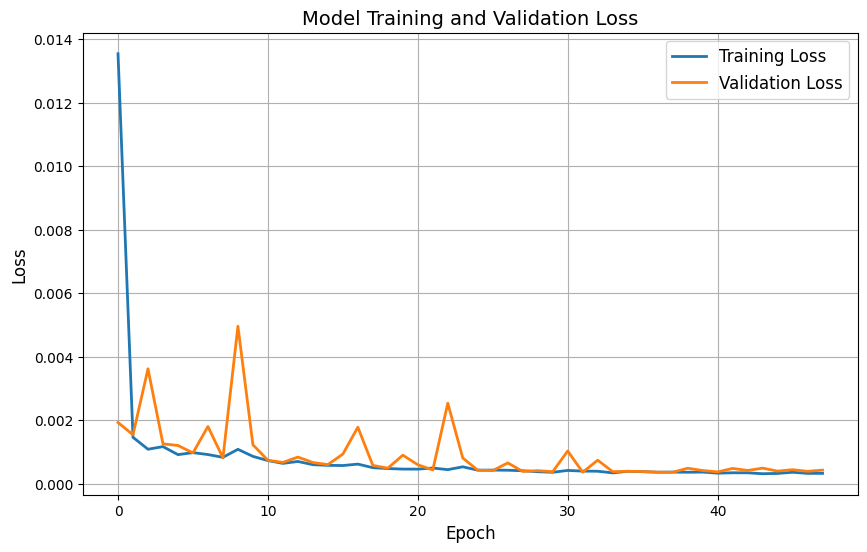

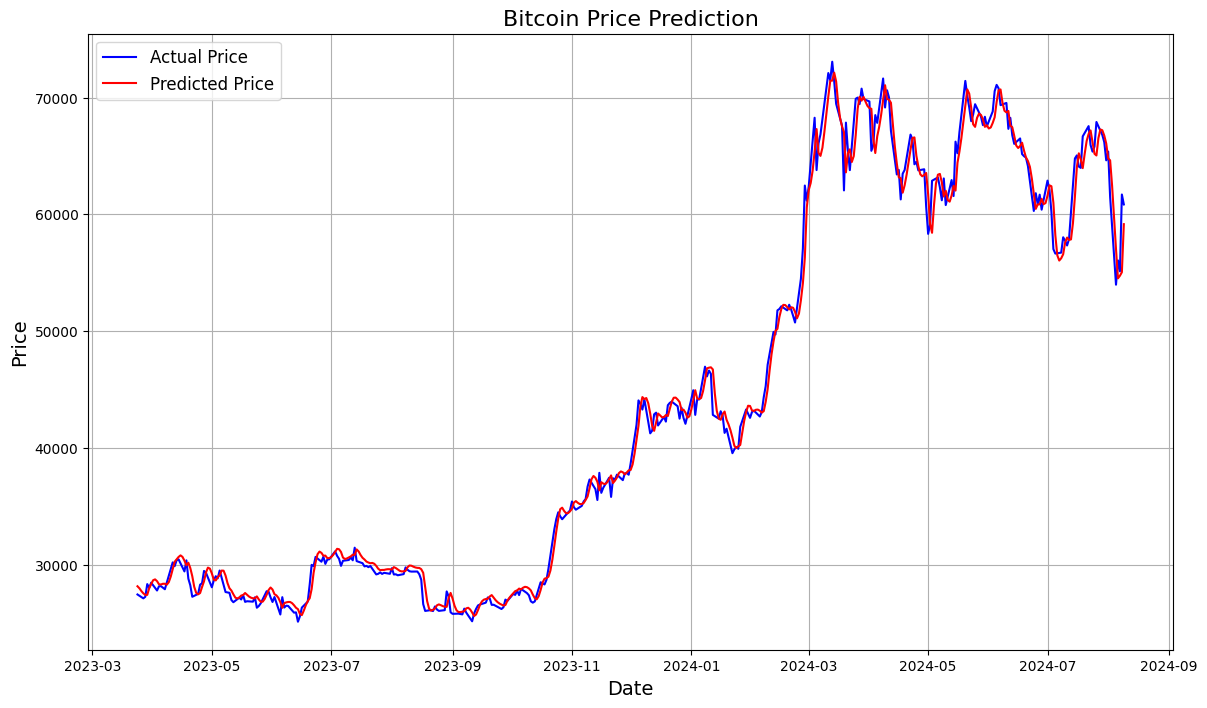

In [ ]:
print("\n=== Evaluating the Model ===")
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
mape = mean_absolute_percentage_error(y_test_actual, predictions)
accuracy = 100 - mape
print(f"\nMAPE: {mape:.2f}%")
print(f"Model Accuracy (100 - MAPE): {accuracy:.2f}%")
# Plot Training and Validation Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Training and Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
# Plot Actual vs. Predicted Prices on the Test Set
test_dates = combined_df.index[training_data_len:]
test_dates = test_dates[:len(predictions)]
plt.figure(figsize=(14, 8))
plt.plot(test_dates, y_test_actual, label='Actual Price', color='blue')
plt.plot(test_dates, predictions, label='Predicted Price', color='red')
plt.title('Bitcoin Price Prediction', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [ ]:
# Real-Time Prediction Using Live API Data
# This real-time demo uses the hyper-tuned model.
current_sequence = train_data_scaled[-seq_length:].flatten().tolist()
print("\n=== Real-Time Prediction (Live API Data) ===")
print("Press Enter to fetch new data, or type 'q' to quit.")

while True:
    user_input = input("Press Enter to fetch new data, or type 'q' to quit: ")
    if user_input.lower() == 'q':
        print("Exiting real-time prediction.")
        break

    live_price = fetch_current_bitcoin_price()
    if live_price is not None:
        print(f"Current live Bitcoin price: ${live_price:.2f}")
        # Scale the new price using the previously fitted scaler
        new_price_scaled = scaler.transform([[live_price]])[0][0]
        current_sequence.append(new_price_scaled)
        current_sequence = current_sequence[-seq_length:]
        sequence_array = np.array(current_sequence).reshape(1, seq_length, 1)
        next_price_scaled = model.predict(sequence_array)
        next_price = scaler.inverse_transform(next_price_scaled)
        print(f"Predicted next price: ${next_price[0][0]:.2f}")
    else:
        print("Skipping prediction due to data fetching error.")


=== Real-Time Prediction (Live API Data) ===
Press Enter to fetch new data, or type 'q' to quit.
Press Enter to fetch new data, or type 'q' to quit: 78945
Current live Bitcoin price: $85829.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
Predicted next price: $59969.41
Press Enter to fetch new data, or type 'q' to quit: 82436
Current live Bitcoin price: $85829.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Predicted next price: $86377.85
Press Enter to fetch new data, or type 'q' to quit: 84800
Current live Bitcoin price: $85829.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted next price: $93554.88
Press Enter to fetch new data, or type 'q' to quit: 90534
Current live Bitcoin price: $85829.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted next price: $89755.88
Press Enter to fetch new data, or type 'q' to quit: 87965
Current live Bitcoin price: $85872.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted next price: $84965.20
Press Enter to fetch new data, or type 'q' to quit: 87904
Current live

In [ ]:
# List to store prediction results
results = []

# Initialize the current sequence using the last `seq_length` values from train_data_scaled
current_sequence = train_data_scaled[-seq_length:].flatten().tolist()

print("\n=== Real-Time Prediction (Live API Data) ===")

# Define the number of iterations and interval in seconds between predictions
num_iterations = 10
interval_seconds = 10

for i in range(num_iterations):
    live_price = fetch_current_bitcoin_price()
    if live_price is not None:
        current_date = pd.Timestamp.now()
        print(f"Date: {current_date}, Live Bitcoin Price: ${live_price:.2f}")

        # Scale the live price using the previously fitted scaler
        new_price_scaled = scaler.transform([[live_price]])[0][0]
        current_sequence.append(new_price_scaled)
        current_sequence = current_sequence[-seq_length:]

        # Prepare the sequence for model prediction
        sequence_array = np.array(current_sequence).reshape(1, seq_length, 1)
        next_price_scaled = model.predict(sequence_array)
        next_price = scaler.inverse_transform(next_price_scaled)
        predicted_price = next_price[0][0]
        print(f"Predicted next price: ${predicted_price:.2f}")

        # Append results with date, actual live price, and predicted next price
        results.append({
            "date": current_date,
            "actual": live_price,
            "predicted": predicted_price
        })
    else:
        print("Skipping prediction due to data fetching error.")

    time.sleep(interval_seconds)

# Convert results to a DataFrame and save to a CSV file
results_df = pd.DataFrame(results)
output_csv = "predicted_data.csv"
results_df.to_csv(output_csv, index=False)
print(f"Predicted data saved to '{output_csv}'")



=== Real-Time Prediction (Live API Data) ===
Date: 2025-03-04 18:23:51.854912, Live Bitcoin Price: $85637.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted next price: $59851.55
Date: 2025-03-04 18:24:02.025167, Live Bitcoin Price: $85607.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
Predicted next price: $86143.65
Date: 2025-03-04 18:24:12.192921, Live Bitcoin Price: $85607.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted next price: $93304.97
Date: 2025-03-04 18:24:22.357030, Live Bitcoin Price: $85607.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Predicted next price: $89537.11
Date: 2025-03-04 18:24:32.523920, Live Bitcoin Price: $85607.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted next price: $84737.44
Date: 2025-03-04 18:24:42.686872, Live Bitcoin Price: $85607.00
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Predicted next price: $82365.26
Error fetching real-time data: 429 Client Error: Too Many Requests for url: https://api.coingecko.com/api/v3/simple/price?ids=bitcoin&vs_currencies=us

In [ ]:
files.download("predicted_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>